## Table of Contents
<a href="#1">1. Data Wrangling</a>  
<a href="#2">2. Preliminary Analysis</a>  
<a href="#3">3. Train/Test Split</a>  
<a href="#4">4. Models Part 1: Using only histical closing prices</a>  
<a href="#5">5. Models Part 2: Using multiple variable based features</a>  



## Data Wrangling<a name="1"></a>

The Apple (AAPL) stock data is from the CRSP database. The sample period spans 6 years from 2013 to 2018. 

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
# import Apple stock data as a dataframe
AAPL = pd.read_csv('/Users/meiliu/Documents/SpringBoard Related/AAPL_Stock.csv')
AAPL.head()

,PERMNO,date,TICKER,DCLRDT,DIVAMT,BIDLO,ASKHI,PRC,VOL,BID,ASK,SHROUT,CFACPR,CFACSHR,OPENPRC,NUMTRD,sprtrn
0,14593,01/02/2013,AAPL,NaN,NaN,541.63000,555.00000,549.03003,21037195,548.70001,548.71002,938973,7,7,553.82001,151041,0.025403
1,14593,01/03/2013,AAPL,NaN,NaN,541.00000,549.66998,542.09589,13297102,542.27002,542.44000,938973,7,7,547.88000,95452,-0.002086
2,14593,01/04/2013,AAPL,NaN,NaN,525.82861,538.62988,527.00000,22087524,526.81000,527.01001,938973,7,7,536.96503,151801,0.004865
3,14593,01/07/2013,AAPL,NaN,NaN,515.20001,529.29999,523.90002,18017331,523.96997,524.19000,938973,7,7,522.00000,127922,-0.003123
4,14593,01/08/2013,AAPL,NaN,NaN,521.25000,531.89001,525.31000,16916775,525.15997,525.40002,938973,7,7,529.21002,113763,-0.003242


In [3]:
# check the AAPL dataframe - there are 1510 trading days over the sample period
print(AAPL.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1510 entries, 0 to 1509
Data columns (total 17 columns):
PERMNO     1510 non-null int64
date       1510 non-null object
TICKER     1510 non-null object
DCLRDT     25 non-null object
DIVAMT     25 non-null float64
BIDLO      1510 non-null float64
ASKHI      1510 non-null float64
PRC        1510 non-null float64
VOL        1510 non-null int64
BID        1510 non-null float64
ASK        1510 non-null float64
SHROUT     1510 non-null int64
CFACPR     1510 non-null int64
CFACSHR    1510 non-null int64
OPENPRC    1510 non-null float64
NUMTRD     1510 non-null int64
sprtrn     1510 non-null float64
dtypes: float64(8), int64(6), object(3)
memory usage: 200.7+ KB
None


In [4]:
# check the non NaN values for DCLRDT and DIVAMT (declaration date and dividend amount)
AAPL[AAPL['DCLRDT'].notnull()][['DCLRDT', 'DIVAMT']].head()

,DCLRDT,DIVAMT
25,01/23/2013,2.65
88,04/23/2013,3.05
151,07/23/2013,3.05
214,10/28/2013,3.05
276,01/27/2014,3.05


In [5]:
# fill NaN values in DIVAMT as 0
AAPL['DIVAMT'].fillna(0, inplace=True)

# set DCLRDT on the decclaration dates =1 and =0 otherwise
dlr_dates = list(AAPL['DCLRDT'][AAPL['DCLRDT'].notnull()])

AAPL['DCLRDT'][AAPL['date'].isin(dlr_dates)] = 1
AAPL['DCLRDT'][~AAPL['date'].isin(dlr_dates)] = 0

# convert the type to bool
AAPL['DCLRDT'] = AAPL['DCLRDT'].astype('bool')

In [6]:
# convert date to DateTime format 
AAPL['date'] = pd.to_datetime(AAPL['date'])

# add day, month, year
AAPL['day'], AAPL['month'], AAPL['year'] = AAPL.date.dt.weekday_name, AAPL.date.dt.month, AAPL.date.dt.year

In [7]:
# adjust variables related to price by CFACPR (the cumulative adjustment factor for price)
AAPL['PRC'] = AAPL['PRC']/AAPL['CFACPR']
AAPL['OPENPRC'] = AAPL['OPENPRC']/AAPL['CFACPR']
AAPL['BIDLO'] = AAPL['BIDLO']/AAPL['CFACPR']
AAPL['ASKHI'] = AAPL['ASKHI']/AAPL['CFACPR']
AAPL['BID'] = AAPL['BID']/AAPL['CFACPR']
AAPL['ASK'] = AAPL['ASK']/AAPL['CFACPR']
AAPL['DIVAMT'] = AAPL['DIVAMT']/AAPL['CFACPR']

In [8]:
# adjust the variables related to number of shares by the CFASHR
AAPL['SHROUT'] = AAPL['SHROUT']*AAPL['CFACSHR']
AAPL['VOL'] = AAPL['VOL']*AAPL['CFACSHR']
AAPL['NUMTRD'] = AAPL['NUMTRD']*AAPL['CFACSHR']

In [9]:
# calculate the bid ask spreads
AAPL['HISPRD'] = AAPL['ASKHI'] - AAPL['BIDLO']
AAPL['SPRD'] = AAPL['ASK'] - AAPL['BID']

In [10]:
# drop unnecessary columns
print(AAPL.columns)
AAPL_clean = AAPL.drop(['PERMNO', 'TICKER', 'BIDLO', 'ASKHI', 'BID', 'ASK', 'SHROUT', 'CFACPR', 'CFACSHR'], axis=1)

Index(['PERMNO', 'date', 'TICKER', 'DCLRDT', 'DIVAMT', 'BIDLO', 'ASKHI', 'PRC',
       'VOL', 'BID', 'ASK', 'SHROUT', 'CFACPR', 'CFACSHR', 'OPENPRC', 'NUMTRD',
       'sprtrn', 'day', 'month', 'year', 'HISPRD', 'SPRD'],
      dtype='object')


In [11]:
# set date as the index of the clean dataframe
AAPL_clean.set_index('date', inplace=True)
AAPL_clean.head()

,DCLRDT,DIVAMT,PRC,VOL,OPENPRC,NUMTRD,sprtrn,day,month,year,HISPRD,SPRD
date,,,,,,,,,,,,
2013-01-02,False,0.0,78.432861,147260365,79.117144,1057287,0.025403,Wednesday,1,2013,1.910000,0.001430
2013-01-03,False,0.0,77.442270,93079714,78.268571,668164,-0.002086,Thursday,1,2013,1.238569,0.024283
2013-01-04,False,0.0,75.285714,154612668,76.709290,1062607,0.004865,Friday,1,2013,1.828753,0.028573
2013-01-07,False,0.0,74.842860,126121317,74.571429,895454,-0.003123,Monday,1,2013,2.014283,0.031433
2013-01-08,False,0.0,75.044286,118417425,75.601431,796341,-0.003242,Tuesday,1,2013,1.520001,0.034293


## Additional Data

### Google Trend

In [12]:
from pytrends.request import TrendReq

In [13]:
pytrends = TrendReq(hl='en-US', tz=360)

# set keyword(s)
kw_list = ['AAPL share price']

# request over sample period
pytrends.build_payload(kw_list, cat=0, timeframe='2012-12-01 2018-12-31', geo='', gprop='')

# convert to dataframe
df = pytrends.interest_over_time()
df.rename(columns={kw_list[0]:'TREND'}, inplace=True)
df.index = pd.to_datetime(df.index)
df.head()

,TREND,isPartial
date,,
2012-12-01,24,False
2013-01-01,43,False
2013-02-01,22,False
2013-03-01,35,False
2013-04-01,29,False


Google Trends data is only available on a monthly basis for my sample period. To add it as a predictor, I will merge the previous month's trend data to each date in the AAPL data. 

In [14]:
# offset the google trends data by +1 month
df.index = df.index + pd.DateOffset(months=1)

# merge the google trends and the AAPL data by year and month
AAPL_merge = pd.merge(AAPL_clean, df['TREND'], left_on=[AAPL_clean.year, AAPL_clean.month],
         right_on=[df.index.year, df.index.month], how='left')
AAPL_merge.set_index(AAPL_clean.index, inplace=True)
AAPL_merge.drop(['key_0', 'key_1'], axis=1, inplace=True)

AAPL_merge.head()

,DCLRDT,DIVAMT,PRC,VOL,OPENPRC,NUMTRD,sprtrn,day,month,year,HISPRD,SPRD,TREND
date,,,,,,,,,,,,,
2013-01-02,False,0.0,78.432861,147260365,79.117144,1057287,0.025403,Wednesday,1,2013,1.910000,0.001430,24
2013-01-03,False,0.0,77.442270,93079714,78.268571,668164,-0.002086,Thursday,1,2013,1.238569,0.024283,24
2013-01-04,False,0.0,75.285714,154612668,76.709290,1062607,0.004865,Friday,1,2013,1.828753,0.028573,24
2013-01-07,False,0.0,74.842860,126121317,74.571429,895454,-0.003123,Monday,1,2013,2.014283,0.031433,24
2013-01-08,False,0.0,75.044286,118417425,75.601431,796341,-0.003242,Tuesday,1,2013,1.520001,0.034293,24


### Earnings Announcement Information

Data parsed from: https://www.streetinsider.com/ec_earnings.php?sort=earning_date&q=AAPL

In [15]:
# import earning announcement tsv
df = pd.read_csv("/Users/meiliu/Documents/SpringBoard Related/AAPL_earnings.tsv",sep='\t', header=None)
df.columns = ['date', 'QTR', 'EPS', 'EEPS', 'Surprise']
df.head() 

,date,QTR,EPS,EEPS,Surprise
0,10/18/10,Q410,$0.66,$0.58,+$0.08
1,1/18/11,Q111,$0.92,$0.77,+$0.15
2,4/20/11,Q211,$0.91,$0.76,+$0.15
3,7/19/11,Q311,$1.11,$0.83,+$0.28
4,10/18/11,Q411,$1.01,$1.04,-$0.03


In [16]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# convert dollar values to float
df['EPS'] = df['EPS'].replace('[\$,]', '', regex=True).astype(float)
df['EEPS'] = df['EEPS'].replace('[\$,]', '', regex=True).astype(float)
df['Surprise'] = df['Surprise'].replace('[\$,]', '', regex=True).astype(float)

df.head()

,QTR,EPS,EEPS,Surprise
date,,,,
2010-10-18,Q410,0.66,0.58,0.08
2011-01-18,Q111,0.92,0.77,0.15
2011-04-20,Q211,0.91,0.76,0.15
2011-07-19,Q311,1.11,0.83,0.28
2011-10-18,Q411,1.01,1.04,-0.03


In [17]:
# merge the google trends and the AAPL data by year and month
AAPL_merge = pd.merge(AAPL_merge, df[['EPS', 'EEPS', 'Surprise']], left_on=[AAPL_merge.index],
         right_on=[df.index], how='left')

AAPL_merge.set_index('key_0', inplace=True)
AAPL_merge.index.rename('date', inplace=True)

AAPL_merge.head()

,DCLRDT,DIVAMT,PRC,VOL,OPENPRC,NUMTRD,sprtrn,day,month,year,HISPRD,SPRD,TREND,EPS,EEPS,Surprise
date,,,,,,,,,,,,,,,,
2013-01-02,False,0.0,78.432861,147260365,79.117144,1057287,0.025403,Wednesday,1,2013,1.910000,0.001430,24,NaN,NaN,NaN
2013-01-03,False,0.0,77.442270,93079714,78.268571,668164,-0.002086,Thursday,1,2013,1.238569,0.024283,24,NaN,NaN,NaN
2013-01-04,False,0.0,75.285714,154612668,76.709290,1062607,0.004865,Friday,1,2013,1.828753,0.028573,24,NaN,NaN,NaN
2013-01-07,False,0.0,74.842860,126121317,74.571429,895454,-0.003123,Monday,1,2013,2.014283,0.031433,24,NaN,NaN,NaN
2013-01-08,False,0.0,75.044286,118417425,75.601431,796341,-0.003242,Tuesday,1,2013,1.520001,0.034293,24,NaN,NaN,NaN


In [18]:
# create an announcment variable for the 30 trading days on/after the earnings announcement
# (where announcement day = 30 and 29 trading days later = 1)
AAPL_merge['Announce'] =  np.where(AAPL_merge['EPS'].notna(), 30, 0)

for i in range(30):
    AAPL_merge['Announce'] = np.maximum(AAPL_merge['Announce'].values, (AAPL_merge['Announce'].shift()-1).fillna(0).values)

In [19]:
# forward fill the earnings surprise
AAPL_merge['Surprise'] = AAPL_merge['Surprise'].fillna(method='ffill').fillna(0.05/1.13)

In [20]:
# drop EPS, EEPS columns
AAPL_merge.drop(['EPS', 'EEPS'], axis=1, inplace=True)
AAPL_merge.head()

,DCLRDT,DIVAMT,PRC,VOL,OPENPRC,NUMTRD,sprtrn,day,month,year,HISPRD,SPRD,TREND,Surprise,Announce
date,,,,,,,,,,,,,,,
2013-01-02,False,0.0,78.432861,147260365,79.117144,1057287,0.025403,Wednesday,1,2013,1.910000,0.001430,24,0.044248,0.0
2013-01-03,False,0.0,77.442270,93079714,78.268571,668164,-0.002086,Thursday,1,2013,1.238569,0.024283,24,0.044248,0.0
2013-01-04,False,0.0,75.285714,154612668,76.709290,1062607,0.004865,Friday,1,2013,1.828753,0.028573,24,0.044248,0.0
2013-01-07,False,0.0,74.842860,126121317,74.571429,895454,-0.003123,Monday,1,2013,2.014283,0.031433,24,0.044248,0.0
2013-01-08,False,0.0,75.044286,118417425,75.601431,796341,-0.003242,Tuesday,1,2013,1.520001,0.034293,24,0.044248,0.0


## Preliminary Analysis<a name="2"></a>

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set()

#### Stock Price Data Visualization

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(AAPL_merge['PRC'])
plt.xlabel('date')
plt.ylabel('price')
plt.title('AAPL Adj Closing Stock Price', size=14);

The stock price over the sample period on average has an upward trend. At the end of 2018, there is a dramatic decrease in stock price that may be difficult to capture. 

In [ ]:
# calculate the daily stock return (including dividends) using the adj closing price
AAPLret = (AAPL_merge['PRC'].diff()+AAPL_merge['DIVAMT'])/AAPL_merge['PRC'].shift()

plt.figure(figsize=(12,6))
plt.plot(AAPL_merge.index, AAPLret, label='AAPL')
plt.plot(AAPL_merge['sprtrn'], label='SP Index')
plt.xlabel('date')
plt.ylabel('daily return')
plt.title('AAPL Daily Stock Return', size=14)
plt.legend();

The volatility of Apple stock returns is much higher than the S&P index, which is to be expected since Apple is a single stock while the index is a portfolio of stocks. 
When the S&P 500 index has periods of high volatility (late 2015-16 and late 2018), the Apple returns seem to experience higher volatility as well. These periods might arise from increased uncertainty in the overall market.

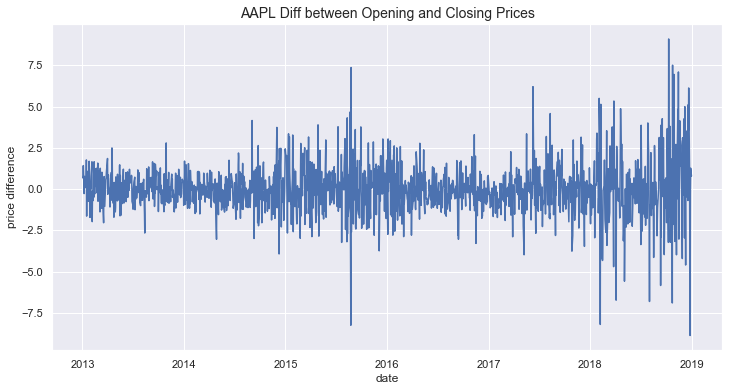

In [23]:
# calculate the difference between opening and closing prices
AAPL_merge['OCdiff'] = AAPL_merge['OPENPRC'] - AAPL_merge['PRC']

plt.figure(figsize=(12,6))
plt.plot(AAPL_merge['OCdiff'])
plt.xlabel('date')
plt.ylabel('price difference')
plt.title('AAPL Diff between Opening and Closing Prices', size=14);

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(AAPL_merge['day'], AAPL_merge['PRC'])
plt.xlabel('day')
plt.ylabel('price')
plt.title('AAPL Closing Price by Day', size=14);

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(AAPL_merge['month'], AAPL_merge['PRC'])
plt.xlabel('month')
plt.ylabel('price')
plt.title('AAPL Closing Price by Month', size=14);

#### Stock Volume Data Visualization

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(AAPL_merge['VOL'])
plt.xlabel('date')
plt.ylabel('volume')
plt.title('AAPL Daily Stock Volume', size=14);

The adjusted volume of AAPL stock decreased from 2013 to 2019. From the graph above, we can see that the stock volume levels out around mid 2014. It may be that with nominally less shares outstanding, a greater percentage were of outstanding shares were traded, leading the adjusted volume to be higher in the period before the stock split. This is consistent with the 7-1 stock split in June 2014.

In [ ]:
# calculate the daily change in volume
volchange = (AAPL_merge['VOL'].diff())/AAPL_merge['VOL'].shift()

plt.figure(figsize=(12,6))
plt.plot(AAPL_merge.index, volchange, label='Change in Volume')
plt.xlabel('date')
plt.ylabel('% change in volume')
plt.title('AAPL Daily Change in Stock Volume', size=14);

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(AAPL_merge['day'], AAPL_merge['VOL'])
plt.xlabel('day')
plt.ylabel('volume')
plt.title('AAPL Volume Traded by Day', size=14);

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(AAPL_merge['month'], AAPL_merge['VOL'])
plt.xlabel('day')
plt.ylabel('volume')
plt.title('AAPL Volume Traded by Month', size=14);

#### Other Data Visualization

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(AAPL_merge['TREND'], label='interest')
plt.plot(AAPL_merge['PRC'], label='AAPL Stock Price')
plt.xlabel('date')
plt.legend()
plt.title('Google Trend Interest: \'AAPL share price\'', size=14);

## Splitting Data into Training, Validation, and Test sets<a name="3"></a>

In [26]:
# split data into train and test sets
def testsplit(df, test_size=10):
    train_data = df[:-test_size]
    test_data = df[-test_size:]
    return train_data, test_data

# split training set into train and validation
def validsplit2(train, n_folds=10, test_size=10):
    fold = int(len(train)/n_folds)
    h_start = []
    h_end = [] 
    for x in list(range(n_folds)):
        h_start.append(fold*(x+1)-test_size)
        h_end.append(fold*(x+1))
    return h_start, h_end


train_data, test_data = testsplit(AAPL_merge)
h_start, h_end = validsplit2(train_data)

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train_data.PRC, label='train')
plt.plot(test_data.PRC, label='test')
plt.title('Training and Test Split', size=14)
plt.legend();

In [ ]:
AAPL_holdout = AAPL[h_start[0]:h_end[0]]
for i in range(9):
    AAPL_holdout = AAPL_holdout.append(AAPL[h_start[i+1]:h_end[i+1]])
AAPL_holdout.set_index('date', inplace=True)

plt.figure(figsize=(12,6))
plt.plot(train_data.PRC, label='train')
plt.plot(test_data.PRC, label='test')
for i in range(10):
    plt.plot(AAPL_holdout.PRC[i*10:(i+1)*10], color='green')
plt.title('Training, Validation, and Test Split', size=14)
plt.legend();


## Forecasting Models I: Using only historical price<a name="4"></a>

### Simple Moving Average<a name="MA"></a>

In [27]:
# RMSE calculation function
def rmse(pred, target):
    return np.sqrt(((pred - target) ** 2).mean())

In [28]:
# moving average prediction incorporating forecasted values (training data only)
# predicts the closing price for the next 10 trading days
def MovingAvgPred(window, h_start=h_start, data=AAPL_merge, test_size=10, col='PRC'):
    pred = []
    N = int(len(h_start))
    for n in range(N):
        h_num = n
        psum=0
        if len(pred)-n*N < window:
            for i in range(min(window,test_size)):
                tsum = data.reset_index()[col][h_start[n]-(window-i):h_start[n]].sum()
                if i != 0:
                    psum = sum(pred[-i:])
                pred.append((tsum+psum)/window)
                
        for i in range(max(0,test_size-window)):
            psum = sum(pred[-window:])
            pred.append(psum/window)
            
    return pred

In [ ]:
# calculate the RMSE of moving averages with windows from 1( aka Last Value) to 30 periods
MA_RMSE = []
for i in range(1,30):
    RMSE = rmse(MovingAvgPred(i), AAPL_holdout.PRC)
    MA_RMSE.append(RMSE)


plt.figure(figsize=(12,6))
plt.plot(MA_RMSE)
plt.xlabel('window')
plt.ylabel('RMSE')
plt.title('RMSE of Moving Average on Validation Periods', size=14);

In [ ]:
# find the moving average window with the lowest error on the validation set
print('A moving average with a {} period window has the minimum RMSE of {}'
      .format(MA_RMSE.index(min(MA_RMSE))+1, min(MA_RMSE)))

In [ ]:
# use the 12-period moving average to predict the test values
test_pred = MovingAvgPred(12, h_start=[1500])
print('Using a 12 period moving average, the prediction on the test data has a RMSE of', rmse(test_pred, test_data.PRC))

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(AAPL_merge['2018']['PRC'])
plt.plot(test_data.index, test_pred, label='predicted')
plt.plot(test_data.PRC, label='actual')
plt.xlabel('date')
plt.ylabel('price')
plt.title('AAPL Stock Price Prediction with a 12 Period Moving Average', size=14)
plt.legend();


In [ ]:
plt.figure(figsize=(12,6))
plt.plot(AAPL_merge['PRC'], label='actual')
plt.plot(test_data.index, test_pred, label='test pred')
plt.plot(AAPL_holdout.index[0:10], MovingAvgPred(12)[0:10], color='red', label='validation pred')
for i in range(1,10):
    plt.plot(AAPL_holdout.index[i*10:(i+1)*10], MovingAvgPred(12)[i*10:(i+1)*10], color='red')
plt.xlabel('date')
plt.ylabel('price')
plt.title('AAPL Stock Price Prediction with a 12 Period Moving Average', size=14)
plt.legend();

The moving average prediction results in a fairly flat forecast, since successive predictions are based on previous ones.

### ARIMA Model

In [ ]:
from pandas.plotting import lag_plot
plt.figure(figsize=(8,8))
lag_plot(train_data['PRC'], lag=5)
plt.title('AAPL Lag Plot for Closing Price (lag=5)', size=14);

In [ ]:
# Test for non-stationarity
from statsmodels.tsa.stattools import adfuller

result = adfuller(train_data.PRC)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

In [ ]:
# estimate values for d and D to use in autoarima
from pmdarima.arima import ndiffs, nsdiffs

print('d: ', ndiffs(train_data.PRC, test='adf'))
print('D: ', nsdiffs(train_data.PRC, 12))

In [ ]:
# below, we can visually confirm that d=1:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(train_data.PRC)
plot_acf(train_data.PRC.diff().dropna());

In [ ]:
from pmdarima import auto_arima

In [ ]:
model = auto_arima(train_data.PRC, start_p=1, start_q=1,max_p=5, max_q=3, m=12,start_P=0, 
                   seasonal=True,d=1, D=0, trace=True,error_action='ignore',suppress_warnings=True)

# fit the autoarima model to the training data
model.fit(train_data.PRC)

In [ ]:
# forecast the next 10 periods
forecast = model.predict(n_periods=10)

# calculate the RMSE of the test predictions
rmse(forecast, test_data.PRC)

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(AAPL_merge['2018']['PRC'])
plt.plot(test_data.index, forecast, label='predicted')
plt.plot(test_data.PRC, label='actual')
plt.xlabel('date')
plt.ylabel('price')
plt.title('AAPL Stock Price Prediction with AutoARIMA', size=14)
plt.legend();

### Prophet

In [ ]:
from fbprophet import Prophet

In [ ]:
# create a training data dataframe in the Prophet format
train_prophet = pd.DataFrame(index=list(range(len(train_data))), columns=['ds', 'y'])
train_prophet['ds'] = train_data.index
train_prophet['y'] = train_data.reset_index().PRC
train_prophet.head()

In [ ]:
# fit the model on the training data
model=Prophet()
model.fit(train_prophet)

In [ ]:
# forecast the test values and calculate the RMSE
pred_prophet = pd.DataFrame(index=list(range(10)), columns=['ds'])
pred_prophet['ds']=test_data.index
forecast = model.predict(pred_prophet)
print(rmse(forecast['yhat'], test_data.reset_index().PRC))

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(AAPL_merge['2018'].PRC)
plt.plot(forecast['ds'], forecast['yhat'], label='predicted')
plt.plot(test_data.PRC, label='actual')
plt.xlabel('date')
plt.ylabel('price')
plt.title('AAPL Stock Price Prediction with FB Prophet', size=14)
plt.legend();

In [ ]:
model.plot_components(forecast);

### XGBoost

#### Feature Selection

In [29]:
# select only the price and date variables
AAPL_XGB = AAPL_merge[['PRC', 'month', 'year']].reset_index()

# create additional features based on date
AAPL_XGB['dayofweek'] = AAPL_XGB['date'].dt.dayofweek
AAPL_XGB['qtr'] = AAPL_XGB['date'].dt.quarter
AAPL_XGB['day365'] = AAPL_XGB['date'].dt.dayofyear
AAPL_XGB['dayofmonth'] = AAPL_XGB['date'].dt.day
AAPL_XGB['weekofyear'] = AAPL_XGB['date'].dt.weekofyear
AAPL_XGB['day_no']=AAPL_XGB.index + 1
# start or end of the week (Mon or Fri)
AAPL_XGB['startend'] =  np.where(AAPL_XGB["dayofweek"].isin(["0", "4"]), 1, 0)

In [54]:
# train test split
train_XGB, test_XGB = testsplit(AAPL_XGB)

In [31]:
# functions to create lag features in training data
def lag_mean_train(col, lags):
    for c in col:
        for x in range(len(lags)):
            train_XGB['{}_moving_mean_{}'.format(c, lags[x])] = train_XGB[c].shift(1).rolling(lags[x]).mean()

def lag_median_train(col, lags):
    for c in col:
        for x in range(len(lags)):
            train_XGB['{}_moving_median_{}'.format(c, lags[x])] = train_XGB[c].shift(1).rolling(lags[x]).median()

def lag_min_train(col, lags):
    for c in col:
        for x in range(len(lags)):
            train_XGB['{}_moving_min_{}'.format(c, lags[x])] = train_XGB[c].shift(1).rolling(lags[x]).min()

def lag_max_train(col, lags):
    for c in col:
        for x in range(len(lags)):
            train_XGB['{}_moving_max_{}'.format(c, lags[x])] = train_XGB[c].shift(1).rolling(lags[x]).max()

In [32]:
# functions to extend lag features to test data:

# calculate moving average
def lag_mean_test(col, lags):
    for c in col:
        for x in range(len(lags)):
            test_XGB['{}_moving_mean_{}'.format(c, lags[x])] = MovingAvgPred(5, h_start=[1500], col=c)

# extend the last value of the moving median, min, max from the training data to the test data
def lag_median_test(col, lags):
    for c in col:
        for x in range(len(lags)):
            test_XGB['{}_moving_median_{}'.format(c, lags[x])] = [train_XGB['{}_moving_median_{}'.format(c, lags[x])].iloc[-1]]*10

def lag_max_test(col, lags):
    for c in col:
        for x in range(len(lags)):
            test_XGB['{}_moving_max_{}'.format(c, lags[x])] = [train_XGB['{}_moving_max_{}'.format(c, lags[x])].iloc[-1]]*10

def lag_min_test(col, lags):
    for c in col:
        for x in range(len(lags)):
            test_XGB['{}_moving_min_{}'.format(c, lags[x])] = [train_XGB['{}_moving_min_{}'.format(c, lags[x])].iloc[-1]]*10



In [55]:
# short term lags of 5,10,15 for moving mean and median
# additional long term lag of 50 for max and min

lags1 = [5,10,15]
lags2 = [5,10,15,50]
col = ['PRC']

# create closing price lag features for training data
lag_mean_train(col, lags1)
lag_median_train(col, lags1)
lag_min_train(col, lags2)
lag_max_train(col, lags2)

# create closing price lag features for test data
lag_mean_test(col, lags1)
lag_median_test(col, lags1)
lag_min_test(col, lags2)
lag_max_test(col, lags2)

In [56]:
# create encodes using training data and merge to both training and test data
def encode_traintest(col, train_XGB, test_XGB):
    for c in col:
        week_encode = train_XGB.groupby('weekofyear')[c].mean().rename('{}_week_encode'.format(c))
        month_encode = train_XGB.groupby('month')[c].mean().rename('{}_month_encode'.format(c))
        year_encode = train_XGB.groupby('year')[c].mean().rename('{}_year_encode'.format(c))

            # merge encodes to training and test data
        encodes = [week_encode, month_encode, year_encode]
        encode_type = ['weekofyear', 'month', 'year']

        for i in range(3):
            train_XGB = pd.merge(train_XGB, encodes[i], left_on=train_XGB[encode_type[i]], right_on=encodes[i].index, how='left').drop('key_0', axis=1)
            test_XGB = pd.merge(test_XGB, encodes[i], left_on=test_XGB[encode_type[i]], right_on=encodes[i].index, how='left').drop('key_0', axis=1)
    return train_XGB, test_XGB

In [57]:
# create & merge encodes
train_XGB, test_XGB = encode_traintest(['PRC'],train_XGB, test_XGB)

In [58]:
# remove the rows with NaN values (first 50 rows) from the training data
train_XGB.dropna(inplace=True)

train_XGB.head()

,date,PRC,month,year,dayofweek,qtr,day365,dayofmonth,weekofyear,day_no,...,PRC_moving_min_10,PRC_moving_min_15,PRC_moving_min_50,PRC_moving_max_5,PRC_moving_max_10,PRC_moving_max_15,PRC_moving_max_50,PRC_week_encode,PRC_month_encode,PRC_year_encode
50,2013-03-15,63.380000,3,2013,4,1,74,15,11,51,...,60.007141,60.007141,60.007141,62.552857,62.552857,64.401429,78.432861,114.427239,114.929545,67.51926
51,2013-03-18,65.102857,3,2013,0,1,77,18,12,52,...,60.007141,60.007141,60.007141,63.380000,63.380000,64.138571,77.442270,114.556922,114.929545,67.51926
52,2013-03-19,64.927141,3,2013,1,1,78,19,12,53,...,60.808856,60.007141,60.007141,65.102857,65.102857,65.102857,75.285714,114.556922,114.929545,67.51926
53,2013-03-20,64.582856,3,2013,2,1,79,20,12,54,...,60.808856,60.007141,60.007141,65.102857,65.102857,65.102857,75.044286,114.556922,114.929545,67.51926
54,2013-03-21,64.675716,3,2013,3,1,80,21,12,55,...,61.192859,60.007141,60.007141,65.102857,65.102857,65.102857,75.044286,114.556922,114.929545,67.51926


In [60]:
# target is PRC
y_train = train_XGB['PRC']
X_train = train_XGB.drop(['PRC', 'date'], axis=1)
print(X_train.columns)

y_test = test_XGB['PRC']
X_test = test_XGB.drop(['PRC', 'date'], axis=1)

Index(['month', 'year', 'dayofweek', 'qtr', 'day365', 'dayofmonth',
       'weekofyear', 'day_no', 'startend', 'PRC_moving_mean_5',
       'PRC_moving_mean_10', 'PRC_moving_mean_15', 'PRC_moving_median_5',
       'PRC_moving_median_10', 'PRC_moving_median_15', 'PRC_moving_min_5',
       'PRC_moving_min_10', 'PRC_moving_min_15', 'PRC_moving_min_50',
       'PRC_moving_max_5', 'PRC_moving_max_10', 'PRC_moving_max_15',
       'PRC_moving_max_50', 'PRC_week_encode', 'PRC_month_encode',
       'PRC_year_encode'],
      dtype='object')


#### <font color="red"><i>(Code below is still in progress)</i></font>

In [38]:
from xgboost import XGBRegressor

In [39]:
def mape(pred, target): 
    return (np.abs(target - pred) / target).mean() * 100

In [40]:
# check default parameters for XGBoost to create grid search parameters
XGBRegressor(eval_metric='rmse')

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [41]:
# set initial values for tuning parameters
n_estimators_1 = 100
max_depth_1 = 8
min_child_weight_1 = 1
subsample_1 = 0.8
colsample_bytree_1 = 0.8
gamma_1 = 0

In [42]:
# adjust the holdout index values for the first 50 removed rows
h_start_xgb = np.array(h_start)-50
h_end_xgb = np.array(h_end)-50

In [43]:
def n_estimators_tune(start, stop, stepsize):
    best_mape = 1000 # initialize val
    
    for n in range(start, stop, stepsize):
        model = XGBRegressor(n_estimators=n, booster='gbtree', eval_metric='rmse', eta=0.03, 
                             max_depth=max_depth_1, min_child_weight=min_child_weight_1, 
                             subsample=subsample_1,colsample_bytree=colsample_bytree_1, gamma=gamma_1, silent=1)
        
        mape_n=[]
        for i in range(len(h_start)):
            model.fit(X_train[:h_start_xgb[i]], y_train[:h_start_xgb[i]])
            pred = model.predict(X_train[h_start_xgb[i]:h_end_xgb[i]])
            mape_n.append(mape(pred, y_train[h_start_xgb[i]:h_end_xgb[i]]))

        if np.mean(mape_n) < best_mape:
            best_mape = np.mean(mape_n)
            best_value = n
        
    print('n_estimators={} has the lowest mape: {}'.format(best_value, best_mape))
    return  best_value

In [44]:
def gamma_tune(start, stop, stepsize):
    best_mape = 1000 # initialize val
    
    for n in range(start, stop, stepsize):
        mape_n=[]
        model = XGBRegressor(gamma=n, booster='gbtree', eval_metric='rmse', eta=0.03, 
                             n_estimators=n_estimators_1, max_depth=max_depth_1, min_child_weight=min_child_weight_1,
                             subsample=subsample_1, colsample_bytree=colsample_bytree_1, silent=1)
        
        for i in range(len(h_start)):
            model.fit(X_train[:h_start_xgb[i]], y_train[:h_start_xgb[i]])
            pred = model.predict(X_train[h_start_xgb[i]:h_end_xgb[i]])
            mape_n.append(mape(pred, y_train[h_start_xgb[i]:h_end_xgb[i]]))

        if np.mean(mape_n) < best_mape:
            best_mape = np.mean(mape_n)
            best_value = n
    print('gamma={} has the lowest mape: {}'.format(best_value, best_mape))  
    return  best_value

In [45]:
# enter inputs as pecentage 
def sample_tune(start_sub, stop_sub, start_col, stop_col, stepsize1, stepsize2=None):
    best_mape = 1000 # initialize val
    
    if stepsize2==None:
        stepsize2=stepsize1
    
    for s in range(start_sub, stop_sub, stepsize1):
        for c in range(start_col, stop_col, stepsize2):
            mape_n=[]
            model = XGBRegressor(subsample=s/100, colsample_bytree=c/100, booster='gbtree', eval_metric='rmse', eta=0.03, 
                                 n_estimators=n_estimators_1, max_depth=max_depth_1, min_child_weight=min_child_weight_1,
                                 gamma=gamma_1, silent=1)

            for i in range(len(h_start)):
                model.fit(X_train[:h_start_xgb[i]], y_train[:h_start_xgb[i]])
                pred = model.predict(X_train[h_start_xgb[i]:h_end_xgb[i]])
                mape_n.append(mape(pred, y_train[h_start_xgb[i]:h_end_xgb[i]]))

            if np.mean(mape_n) < best_mape:
                best_mape = np.mean(mape_n)
                best_value1 = s/100
                best_value2 = c/100
    print('subsample={} and colsample_bytree={} has the lowest mape: {}'.format(best_value1, best_value2, best_mape))  
    return  best_value1, best_value2

In [46]:
def depth_weight_tune(start_depth, stop_depth, start_weight, stop_weight, stepsize1, stepsize2=None):
    best_mape = 1000 # initialize val
    
    if stepsize2==None:
        stepsize2=stepsize1
    
    for d in range(start_depth, stop_depth, stepsize1):
        for w in range(start_weight, stop_weight, stepsize2):
            mape_n=[]
            model = XGBRegressor(max_depth=d, min_child_weight=w, booster='gbtree', eval_metric='rmse', eta=0.03, 
                             n_estimators=n_estimators_1,
                             subsample=subsample_1, colsample_bytree=colsample_bytree_1, gamma=gamma_1, silent=1)

            for i in range(len(h_start)):
                model.fit(X_train[:h_start_xgb[i]], y_train[:h_start_xgb[i]])
                pred = model.predict(X_train[h_start_xgb[i]:h_end_xgb[i]])
                mape_n.append(mape(pred, y_train[h_start_xgb[i]:h_end_xgb[i]]))

            if np.mean(mape_n) < best_mape:
                best_mape = np.mean(mape_n)
                best_value1 = d
                best_value2 = w
    print('max_depth={} and min_child_weight={} has the lowest mape: {}'.format(best_value1, best_value2, best_mape))  
    return  best_value1, best_value2

In [47]:
n_estimators_1 = n_estimators_tune(50,500,50)

KeyboardInterrupt: 

In [ ]:
gamma_1 = gamma_tune(0, 8, 1)

In [ ]:
subsample_1, colsample_bytree_1 = sample_tune(50,100,50,100,10)

In [ ]:
max_depth_1, min_child_weight_1 = depth_weight_tune(3,12,1,10,1)

In [ ]:
print('Tuned Parameter Values:\n n_estimators={},\n max_depth={},\n min_child_weight={},\n subsample={},\n colsample_bytree={},\n gamma={}'.format(n_estimators_1, max_depth_1, min_child_weight_1, subsample_1, colsample_bytree_1, gamma_1))

In [61]:
model = XGBRegressor(booster='gbtree', eval_metric='rmse', eta=0.03,
             n_estimators=n_estimators_1, max_depth=max_depth_1, min_child_weight=min_child_weight_1,
             subsample=subsample_1,colsample_bytree=colsample_bytree_1, gamma=gamma_1, silent=1)

In [62]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.03,
             eval_metric='rmse', gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
             subsample=0.8, verbosity=1)

In [63]:
y_pred = model.predict(X_test)
print('RMSE of test prediction:', rmse(y_pred, y_test))
print('MAPE of test prediction:', mape(y_pred, y_test))

RMSE of test prediction: 10.847160049328311
MAPE of test prediction: 6.09053187579776


In [52]:
X_test.columns

Index(['month', 'year', 'dayofweek', 'qtr', 'day365', 'dayofmonth',
       'weekofyear', 'day_no', 'startend', 'PRC_moving_mean_5',
       'PRC_moving_mean_10', 'PRC_moving_mean_15', 'PRC_moving_median_5',
       'PRC_moving_median_10', 'PRC_moving_median_15', 'PRC_moving_max_5',
       'PRC_moving_max_10', 'PRC_moving_max_15', 'PRC_moving_max_50',
       'PRC_moving_min_5', 'PRC_moving_min_10', 'PRC_moving_min_15',
       'PRC_moving_min_50', 'PRC_week_encode', 'PRC_month_encode',
       'PRC_year_encode'],
      dtype='object')

In [53]:
X_train.columns

Index(['month', 'year', 'dayofweek', 'qtr', 'day365', 'dayofmonth',
       'weekofyear', 'day_no', 'startend', 'PRC_moving_mean_5',
       'PRC_moving_mean_10', 'PRC_moving_mean_15', 'PRC_moving_median_5',
       'PRC_moving_median_10', 'PRC_moving_median_15', 'PRC_moving_min_5',
       'PRC_moving_min_10', 'PRC_moving_min_15', 'PRC_moving_min_50',
       'PRC_moving_max_5', 'PRC_moving_max_10', 'PRC_moving_max_15',
       'PRC_moving_max_50', 'PRC_week_encode', 'PRC_month_encode',
       'PRC_year_encode'],
      dtype='object')

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(AAPL_merge['2018']['PRC'])
plt.plot(test_data.index, y_pred, label='predicted')
plt.plot(test_data.PRC, label='actual')
plt.xlabel('date')
plt.ylabel('price')
plt.title('AAPL Stock Price Prediction with XGBoost', size=14)
plt.legend();

## Forecasting Models II: Using multiple features<a name="5"></a>

#### Feature Selection

In [64]:
# select only the price and date variables
AAPL_XGB = AAPL_merge.reset_index()

# create additional features based on date
AAPL_XGB['dayofweek'] = AAPL_XGB['date'].dt.dayofweek
AAPL_XGB['qtr'] = AAPL_XGB['date'].dt.quarter
AAPL_XGB['day365'] = AAPL_XGB['date'].dt.dayofyear
AAPL_XGB['dayofmonth'] = AAPL_XGB['date'].dt.day
AAPL_XGB['weekofyear'] = AAPL_XGB['date'].dt.weekofyear
AAPL_XGB['day_no']=AAPL_XGB.index + 1
# start or end of the week (Mon or Fri)
AAPL_XGB['startend'] =  np.where(AAPL_XGB["dayofweek"].isin(["0", "4"]), 1, 0)

In [65]:
# train test split
train_XGB, test_XGB = testsplit(AAPL_XGB)

In [66]:
# short term lags of 5,10,15 for moving mean and median
# additional long term lag of 50 for max and min

lags1 = [5,10,15]
lags2 = [5,10,15,50]
col = ['PRC', 'VOL', 'NUMTRD', 'sprtrn', 'HISPRD', 'SPRD', 'OCdiff']

# create closing price lag features for training data
lag_mean_train(col, lags1)
lag_median_train(col, lags1)
lag_min_train(col, lags2)
lag_max_train(col, lags2)

# create closing price lag features for test data
lag_mean_test(col, lags1)
lag_median_test(col, lags1)
lag_min_test(col, lags2)
lag_max_test(col, lags2)

In [67]:
# create encodes on price
train_XGB, test_XGB = encode_traintest(['PRC'], train_XGB, test_XGB)

In [68]:
# remove the rows with NaN values (first 50 rows) from the training data
train_XGB.dropna(inplace=True)

train_XGB.head()

,date,DCLRDT,DIVAMT,PRC,VOL,OPENPRC,NUMTRD,sprtrn,day,month,...,SPRD_moving_max_10,SPRD_moving_max_15,SPRD_moving_max_50,OCdiff_moving_max_5,OCdiff_moving_max_10,OCdiff_moving_max_15,OCdiff_moving_max_50,PRC_week_encode,PRC_month_encode,PRC_year_encode
50,2013-03-15,False,0.0,63.380000,166699778,62.561427,1014804,-0.001618,Friday,3,...,0.034284,0.034284,0.035714,1.024289,1.264003,1.578574,1.768569,114.427239,114.929545,67.51926
51,2013-03-18,False,0.0,65.102857,156891679,63.064287,999432,-0.005510,Monday,3,...,0.034284,0.034284,0.035714,1.024289,1.264003,1.578574,1.768569,114.556922,114.929545,67.51926
52,2013-03-19,False,0.0,64.927141,138683853,65.642857,966812,-0.002423,Tuesday,3,...,0.034284,0.034284,0.035714,1.024289,1.264003,1.264003,1.768569,114.556922,114.929545,67.51926
53,2013-03-20,False,0.0,64.582856,79814847,65.345716,540218,0.006697,Wednesday,3,...,0.034284,0.034284,0.035714,0.715716,1.264003,1.264003,1.768569,114.556922,114.929545,67.51926
54,2013-03-21,False,0.0,64.675716,100521904,64.317143,683256,-0.008282,Thursday,3,...,0.034284,0.034284,0.035714,0.762860,1.024289,1.264003,1.768569,114.556922,114.929545,67.51926


In [69]:
train_XGB.columns[:25]

Index(['date', 'DCLRDT', 'DIVAMT', 'PRC', 'VOL', 'OPENPRC', 'NUMTRD', 'sprtrn',
       'day', 'month', 'year', 'HISPRD', 'SPRD', 'TREND', 'Surprise',
       'Announce', 'OCdiff', 'dayofweek', 'qtr', 'day365', 'dayofmonth',
       'weekofyear', 'day_no', 'startend', 'PRC_moving_mean_5'],
      dtype='object')

In [70]:
# target is PRC
# drop variables such as VOL which are only used to generate lag features
y_train = train_XGB['PRC']
X_train = train_XGB.drop(['PRC', 'date', 'VOL', 'OPENPRC', 'NUMTRD', 'sprtrn',
       'day', 'HISPRD', 'SPRD', 'OCdiff'], axis=1)
print(X_train.columns)

y_test = test_XGB['PRC']
X_test = test_XGB.drop(['PRC', 'date', 'VOL', 'OPENPRC', 'NUMTRD', 'sprtrn',
       'day', 'HISPRD', 'SPRD', 'OCdiff'], axis=1)

Index(['DCLRDT', 'DIVAMT', 'month', 'year', 'TREND', 'Surprise', 'Announce',
       'dayofweek', 'qtr', 'day365',
       ...
       'SPRD_moving_max_10', 'SPRD_moving_max_15', 'SPRD_moving_max_50',
       'OCdiff_moving_max_5', 'OCdiff_moving_max_10', 'OCdiff_moving_max_15',
       'OCdiff_moving_max_50', 'PRC_week_encode', 'PRC_month_encode',
       'PRC_year_encode'],
      dtype='object', length=115)


In [71]:
# set initial values for tuning parameters
n_estimators_1 = 100
max_depth_1 = 8
min_child_weight_1 = 1
subsample_1 = 0.8
colsample_bytree_1 = 0.8
gamma_1 = 0

In [72]:
model = XGBRegressor(booster='gbtree', eval_metric='rmse', eta=0.03,
             n_estimators=n_estimators_1, max_depth=max_depth_1, min_child_weight=min_child_weight_1,
             subsample=subsample_1,colsample_bytree=colsample_bytree_1, gamma=gamma_1, silent=1)

In [73]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.03,
             eval_metric='rmse', gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
             subsample=0.8, verbosity=1)

In [74]:
y_pred = model.predict(X_test)
print('RMSE of test prediction:', rmse(y_pred, y_test))
print('MAPE of test prediction:', mape(y_pred, y_test))

RMSE of test prediction: 9.999819416333857
MAPE of test prediction: 5.6438024256093176


In [75]:
n_estimators_1 = n_estimators_tune(50,500,50)

n_estimators=150 has the lowest mape: 2.9177822221856213


In [76]:
gamma_1 = gamma_tune(0, 8, 1)

gamma=3 has the lowest mape: 2.6125168533333247


In [77]:
subsample_1, colsample_bytree_1 = sample_tune(50,100,50,100,10)

subsample=0.8 and colsample_bytree=0.8 has the lowest mape: 2.6125168533333247


In [78]:
max_depth_1, min_child_weight_1 = depth_weight_tune(3,12,1,10,1)

max_depth=9 and min_child_weight=7 has the lowest mape: 2.5788773815661212


In [79]:
model = XGBRegressor(booster='gbtree', eval_metric='rmse', eta=0.03,
             n_estimators=n_estimators_1, max_depth=max_depth_1, min_child_weight=min_child_weight_1,
             subsample=subsample_1,colsample_bytree=colsample_bytree_1, gamma=gamma_1, silent=1)

In [80]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.03,
             eval_metric='rmse', gamma=3, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=9,
             min_child_weight=7, missing=None, n_estimators=150, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
             subsample=0.8, verbosity=1)

In [81]:
y_pred = model.predict(X_test)
print('RMSE of test prediction:', rmse(y_pred, y_test))
print('MAPE of test prediction:', mape(y_pred, y_test))

RMSE of test prediction: 11.586447369381597
MAPE of test prediction: 6.692637386505548
